In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Lipinski, Descriptors

#from mining_cleaning import *

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns',35)

## Выгружаем датасеты

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/dataconHack/hackathon/main/data.csv')
drug = pd.read_csv('https://raw.githubusercontent.com/dataconHack/hackathon/main/drug_descriptors.csv')
bacterial = pd.read_csv('https://raw.githubusercontent.com/dataconHack/hackathon/main/bacterial_descriptors.csv')

в датасете обнаружены удвоенные согласные их удаление поможет избежать опечатки и улучшит работу дискриптора

In [4]:
en_al = ['aa', 'bb', 'cc', 'dd', 'ee', 'ff', 'gg', 'hh', 'ii', 'jj', 'kk', 'll', 'mm', 'nn', 'oo', 'pp', 'qq', 'rr', 'ss', 'tt', 'uu', 'vv', 'ww', 'xx', 'yy', 'zz','а','в','е','к','м','о','р','с','т','х']
en_al2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','a','b','e','k','m','o','p','c','t','x']

уберём пробелы точки и заменим удвоения во всех датасетах

In [5]:
def repl(data,col):
    data[col] = data[col].str.replace(' ','').str.lower()
    data[col] = data[col].str.replace('.','')
    for i in range(len(en_al)):
        data[col] = data[col].str.replace(en_al[i],en_al2[i])

In [6]:
repl(bacterial,'Bacteria')
repl(drug,'drug')
repl(data,'Drug')
repl(data,'Bacteria')

C:\Users\Алексей\AppData\Local\Temp\ipykernel_11088\335858236.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[col] = data[col].str.replace('.','')


## Очистка датасетов

In [7]:
bacterial.columns

Index(['Tax_id', 'Bacteria', 'kingdom', 'subkingdom', 'clade', 'phylum',
       'class', 'order', 'family', 'genus', 'species', 'gram',
       'min_Incub_period, h', 'avg_Incub_period, h', 'max_Incub_period, h',
       'growth_temp, C', 'biosafety_level', 'isolated_from'],
      dtype='object')

для начала напишем пару функций

In [8]:
def drop_columns(df_lst: list, columns_lst: list) -> list:
    """Функция дропает в каждом датафрейме в df_lst определенные колонки из columns_lst"""
    
    assert len(df_lst) == len(columns_lst), 'len(df_lst) != len(columns_lst)'
    
    for i in range(len(df_lst)):
        df_lst[i] = df_lst[i].drop(columns_lst[i], axis=1)
        
    return df_lst


def fill_df_descriptors(df_old: pd) -> pd:
    """Возвращает датафрейм с дескрипторами. Функция нужная для работы с drug_descriptors.csv"""
    
    descriptors_lst = []
    
    for smiles in df_old.smiles:
        compound = Chem.MolFromSmiles(smiles)
        
        descriptors_lst.append([Lipinski.NumHDonors(compound), Lipinski.NumHAcceptors(compound), Lipinski.NumHeteroatoms(compound),
                                Descriptors.ExactMolWt(compound), Descriptors.MaxAbsPartialCharge(compound), Descriptors.MaxPartialCharge(compound),
                                Descriptors.MinAbsPartialCharge(compound), Descriptors.MinPartialCharge(compound)])
        
    # Общий датафрейм дескрипторов    
    df_descriptors = pd.DataFrame(descriptors_lst, columns=['NumHDonors', 'NumHAcceptors', 'NumHeteroatoms',
                                                            'ExactMolWt', 'MaxAbsPartialCharge', 'MaxPartialCharge', 
                                                            'MinAbsPartialCharge', 'MinPartialCharge'])
    # Объединяем и получаем итоговый датасет
    df_new = pd.concat([df_old, df_descriptors], axis=1)
        
    return df_new


def zip_data(df_main: pd, df_drug: pd, df_bacterial: pd) -> pd:
    """Функция сшивает все датасеты"""
    
    # Объединение с drug
    df_drug_temporary = pd.DataFrame(columns=df_drug.columns[1:])
    df_drug_temporary_nan = pd.DataFrame(np.nan, index=[0], columns=df_drug.columns[1:])
    
    for drug in df_main['Drug']:
        if not(drug in list(df_drug['drug'])):
            df_drug_temporary = pd.concat([df_drug_temporary, df_drug_temporary_nan], axis=0)
        else:
            df_drug_temporary = pd.concat([df_drug_temporary, df_drug[df_drug['drug'] == drug][list(df_drug.columns[1:])]], axis=0)
            
    # Обновляем индексы        
    df_drug_temporary.reset_index(drop=True, inplace=True)
    
    # Объединение с bacterial 
    df_bacterial_temporary = pd.DataFrame(columns=df_bacterial.columns[1:])
    df_bacterial_temporary_nan = pd.DataFrame(np.nan, index=[0], columns=df_bacterial.columns[1:])
    
    for bacteria in df_main['Bacteria']:
        if not(bacteria in list(df_bacterial['Bacteria'])):
            df_bacterial_temporary = pd.concat([df_bacterial_temporary, df_bacterial_temporary_nan], axis=0)
        else:
            df_bacterial_temporary = pd.concat([df_bacterial_temporary, df_bacterial[df_bacterial['Bacteria'] == bacteria][list(df_bacterial.columns[1:])]], axis=0)
            
    # Обновляем индексы        
    df_bacterial_temporary.reset_index(drop=True, inplace=True)  
    
    # Объединение всех датасетов    
    df_result = pd.concat([df_main, df_drug_temporary, df_bacterial_temporary], axis=1)
    
    return df_result
        

In [9]:
# Список колонок, которые было принято решение удалить
data_drop_lst = ['Unnamed: 0.1', 'Unnamed: 0', 'Drug_class_drug_bank', 'method', 'MDR_check', 'NP_Synthesis', 'NP_concentration', 'Drug_dose', 'ZOI_NP']
drug_drop_lst = ['Unnamed: 0', 'chemID', 'prefered_name']
bacterial_drop_lst = ['Tax_id', 'subkingdom', 'clade', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'isolated_from']

data, drug, bacterial = drop_columns([data, drug, bacterial], [data_drop_lst, drug_drop_lst, bacterial_drop_lst])

In [10]:
drug = fill_df_descriptors(drug)
drug

,drug,smiles,NumHDonors,NumHAcceptors,NumHeteroatoms,ExactMolWt,MaxAbsPartialCharge,MaxPartialCharge,MinAbsPartialCharge,MinPartialCharge
0,amoxicilin,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,4,6,9,365.104542,0.507967,0.327399,0.327399,-0.507967
1,penicilin,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,1,5,8,372.054610,1.000000,1.000000,0.547832,-0.547832
2,vancomycin,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,19,25,35,1447.430200,0.507810,0.330441,0.330441,-0.507810
3,gentamicin,CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H...,8,12,12,477.316249,0.387562,0.185232,0.185232,-0.387562
4,ceftazidime,CC(C)(O/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=...,3,11,15,546.099139,0.543191,0.349825,0.349825,-0.543191
5,ampicilin,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...,3,5,8,349.109627,0.479673,0.327399,0.327399,-0.479673
6,faropenem,C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C([C@H]3CCCO3...,2,5,7,285.067094,0.476538,0.353083,0.353083,-0.476538
7,ceftriaxone,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc...,4,15,18,554.046058,0.488304,0.352159,0.352159,-0.488304
8,rifampicin,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,6,15,16,822.405123,0.506736,0.312109,0.312109,-0.506736
9,azithromycin,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,5,14,14,748.508526,0.458936,0.311188,0.311188,-0.458936


In [11]:
pd.concat([drug[drug['drug'] == np.NaN][list(drug.columns[1:])], drug[drug['drug'] == 'Penicillin'][list(drug.columns[1:])]], axis=0)

,smiles,NumHDonors,NumHAcceptors,NumHeteroatoms,ExactMolWt,MaxAbsPartialCharge,MaxPartialCharge,MinAbsPartialCharge,MinPartialCharge


In [12]:
df_main = zip_data(data, drug, bacterial)

In [13]:
df_main.isna().sum().sort_values(ascending=False)

fold_increase_in_antibacterial_activity (%)    472
ZOI_drug_NP                                    309
ZOI_drug                                       266
Drug                                           251
NumHeteroatoms                                 250
MinAbsPartialCharge                            250
MinPartialCharge                               250
smiles                                         250
NumHDonors                                     250
NumHAcceptors                                  250
ExactMolWt                                     250
MaxAbsPartialCharge                            250
MaxPartialCharge                               250
max_Incub_period, h                             35
min_Incub_period, h                             35
gram                                            18
Bacteria                                        10
shape                                           10
NP size_avg                                     10
NP size_max                    

In [14]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Bacteria                                     883 non-null    object 
 1   Drug                                         642 non-null    object 
 2   NP size_min                                  883 non-null    float64
 3   NP size_max                                  883 non-null    float64
 4   NP size_avg                                  883 non-null    float64
 5   shape                                        883 non-null    object 
 6   ZOI_drug                                     627 non-null    object 
 7   ZOI_drug_NP                                  584 non-null    object 
 8   fold_increase_in_antibacterial_activity (%)  421 non-null    float64
 9   smiles                                       643 non-null    object 
 10  Nu

In [15]:
df_main.describe()

,NP size_min,NP size_max,NP size_avg,fold_increase_in_antibacterial_activity (%),ExactMolWt,MaxAbsPartialCharge,MaxPartialCharge,MinAbsPartialCharge,MinPartialCharge,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h"
count,883.000000,883.000000,883.000000,421.000000,643.000000,643.000000,643.000000,643.000000,643.000000,858.000000,888.000000,858.000000
mean,9.114315,26.572661,18.153341,319.279838,559.002533,0.496427,0.338264,0.306367,-0.464530,36.832821,58.329144,83.904429
std,6.545505,17.665471,12.577573,3763.757601,422.329572,0.145218,0.190030,0.088937,0.054701,45.281508,60.064964,76.055223
min,1.000000,3.000000,3.000000,0.000000,138.008195,0.356452,0.185232,0.185232,-0.547832,0.160000,0.000000,12.000000
25%,5.000000,20.000000,13.500000,0.000000,349.109627,0.394123,0.248700,0.248700,-0.507810,24.000000,36.000000,48.000000
50%,8.000000,20.000000,13.500000,0.100000,477.038884,0.478646,0.327399,0.327399,-0.478646,24.000000,36.000000,72.000000
75%,8.000000,30.000000,20.000000,0.800000,546.099139,0.507810,0.340725,0.340725,-0.394123,42.000000,48.000000,72.000000
max,55.000000,80.000000,62.500000,44774.000000,2391.484204,1.000000,1.000000,0.547832,-0.356452,240.000000,288.000000,336.000000


In [16]:
# Удаляем в ZOI все символы, стоящие после + (включительно)

df_main['ZOI_drug_NP'].replace(['32+'], 32, inplace=True)
df_main['ZOI_drug_NP'].replace(['17+2'], 17, inplace=True)
df_main['ZOI_drug'].replace(['32+'], 17, inplace=True)

In [17]:
#ONE-HOT ENCODING ПРЕОБРАЗОВАНИЕ ВРУЧНУЮ

df_main['shape_spherical'] = df_main['shape']
df_main['shape_nanorods_and_triangles'] = df_main['shape']
df_main['shape_triangular'] = df_main['shape']
df_main = df_main.drop('shape', axis=1)

df_main['shape_spherical'].replace(['nanorods and triangles', 'triangular'], 0, inplace=True)
df_main['shape_spherical'].replace(['spherical'], 1, inplace=True)

df_main['shape_nanorods_and_triangles'].replace(['spherical', 'triangular'], 0, inplace=True)
df_main['shape_nanorods_and_triangles'].replace(['nanorods and triangles'], 1, inplace=True)

df_main['shape_triangular'].replace(['nanorods and triangles', 'spherical'], 0, inplace=True)
df_main['shape_triangular'].replace(['triangular'], 1, inplace=True)


#Столбец ['gram']

df_main['gram_p'] = df_main['gram']	
df_main = df_main.drop('gram', axis=1)

df_main['gram_p'].replace(['n', np.nan], 0, inplace=True)
df_main['gram_p'].replace(['p'], 1, inplace=True)


In [18]:
#ПРКЕОБРАЗОВАНИЕ ТИПОВ

df_main = df_main.astype({'NumHeteroatoms': np.float64, 'NumHAcceptors' : np.float64, 'NumHDonors' : np.float64, 
                          'growth_temp, C' : np.float64, 'biosafety_level' : np.float64, 'shape_spherical' : np.float64, 
                           'ZOI_drug_NP' : np.float64, 'ZOI_drug' : np.float64})


In [19]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 27 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Bacteria                                     883 non-null    object 
 1   Drug                                         642 non-null    object 
 2   NP size_min                                  883 non-null    float64
 3   NP size_max                                  883 non-null    float64
 4   NP size_avg                                  883 non-null    float64
 5   ZOI_drug                                     627 non-null    float64
 6   ZOI_drug_NP                                  584 non-null    float64
 7   fold_increase_in_antibacterial_activity (%)  421 non-null    float64
 8   smiles                                       643 non-null    object 
 9   NumHDonors                                   643 non-null    float64
 10  Nu

удаление пропусков

In [20]:
df_main = df_main[~df_main['Bacteria'].isna()]
df_main = df_main[~df_main['max_Incub_period, h'].isna()]
df_main = df_main[~df_main['gram_p'].isna()]

df_main = df_main[~((df_main['ZOI_drug_NP'].isna()))]
df_main = df_main[~((df_main['ZOI_drug_NP'].isna()) & (df_main['ZOI_drug'].isna()))]
df_main = df_main[~((df_main['ZOI_drug'].isna()))]

df_main = df_main[~df_main['ExactMolWt'].isna()]

df_main = df_main[~df_main['ZOI_drug_NP'].isna()]


In [21]:
df_main

,Bacteria,Drug,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),smiles,NumHDonors,NumHAcceptors,NumHeteroatoms,ExactMolWt,MaxAbsPartialCharge,MaxPartialCharge,MinAbsPartialCharge,MinPartialCharge,kingdom,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,shape_spherical,shape_nanorods_and_triangles,shape_triangular,gram_p
0,escherichiacoli,amoxicilin,4.0,10.0,8.0,17.0000,32.000,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,Bacteria,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
1,escherichiacoli,penicilin,4.0,10.0,8.0,17.0000,32.000,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,1.0,5.0,8.0,372.054610,1.000000,1.000000,0.547832,-0.547832,Bacteria,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
2,escherichiacoli,amoxicilin,15.0,30.0,28.0,17.0000,32.000,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,Bacteria,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
3,escherichiacoli,penicilin,15.0,30.0,28.0,17.0000,32.000,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,1.0,5.0,8.0,372.054610,1.000000,1.000000,0.547832,-0.547832,Bacteria,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
4,micrococusluteus,vancomycin,5.0,30.0,21.0,0.0000,17.000,7.02,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,19.0,25.0,35.0,1447.430200,0.507810,0.330441,0.330441,-0.507810,Bacteria,240.0,288.0,336.0,30.0,1.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,staphylococusaureus,penicilin,4.0,10.0,8.0,1.0000,0.125,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,Bacteria,24.0,36.0,48.0,37.0,2.0,1.0,0.0,0.0,1
580,pseudomonasaeruginosa,mupirocin,5.0,80.0,60.0,0.3125,0.100,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,Bacteria,12.0,18.0,24.0,37.0,2.0,1.0,0.0,0.0,0
581,pasteurelamultocida,penicilin,4.0,10.0,8.0,0.0300,0.030,NaN,CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H...,8.0,12.0,12.0,477.316249,0.387562,0.185232,0.185232,-0.387562,Bacteria,24.0,36.0,48.0,37.0,2.0,1.0,0.0,0.0,1
582,pasteurelamultocida,penicilin,15.0,30.0,28.0,0.0300,0.030,NaN,CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H...,8.0,12.0,12.0,477.316249,0.387562,0.185232,0.185232,-0.387562,Bacteria,24.0,48.0,72.0,37.0,2.0,1.0,0.0,0.0,0


In [22]:
df_main = df_main[df_main['kingdom']=='Bacteria']
df_main

,Bacteria,Drug,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),smiles,NumHDonors,NumHAcceptors,NumHeteroatoms,ExactMolWt,MaxAbsPartialCharge,MaxPartialCharge,MinAbsPartialCharge,MinPartialCharge,kingdom,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,shape_spherical,shape_nanorods_and_triangles,shape_triangular,gram_p
0,escherichiacoli,amoxicilin,4.0,10.0,8.0,17.0000,32.000,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,Bacteria,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
1,escherichiacoli,penicilin,4.0,10.0,8.0,17.0000,32.000,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,1.0,5.0,8.0,372.054610,1.000000,1.000000,0.547832,-0.547832,Bacteria,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
2,escherichiacoli,amoxicilin,15.0,30.0,28.0,17.0000,32.000,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,Bacteria,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
3,escherichiacoli,penicilin,15.0,30.0,28.0,17.0000,32.000,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,1.0,5.0,8.0,372.054610,1.000000,1.000000,0.547832,-0.547832,Bacteria,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
4,micrococusluteus,vancomycin,5.0,30.0,21.0,0.0000,17.000,7.02,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,19.0,25.0,35.0,1447.430200,0.507810,0.330441,0.330441,-0.507810,Bacteria,240.0,288.0,336.0,30.0,1.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,staphylococusaureus,penicilin,4.0,10.0,8.0,1.0000,0.125,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,Bacteria,24.0,36.0,48.0,37.0,2.0,1.0,0.0,0.0,1
580,pseudomonasaeruginosa,mupirocin,5.0,80.0,60.0,0.3125,0.100,NaN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,Bacteria,12.0,18.0,24.0,37.0,2.0,1.0,0.0,0.0,0
581,pasteurelamultocida,penicilin,4.0,10.0,8.0,0.0300,0.030,NaN,CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H...,8.0,12.0,12.0,477.316249,0.387562,0.185232,0.185232,-0.387562,Bacteria,24.0,36.0,48.0,37.0,2.0,1.0,0.0,0.0,1
582,pasteurelamultocida,penicilin,15.0,30.0,28.0,0.0300,0.030,NaN,CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H...,8.0,12.0,12.0,477.316249,0.387562,0.185232,0.185232,-0.387562,Bacteria,24.0,48.0,72.0,37.0,2.0,1.0,0.0,0.0,0


почти все наблюдения у нас бактерии (удалим грибы)

## Анализ данных

In [23]:
df_main.columns

Index(['Bacteria', 'Drug', 'NP size_min', 'NP size_max', 'NP size_avg',
       'ZOI_drug', 'ZOI_drug_NP',
       'fold_increase_in_antibacterial_activity (%)', 'smiles', 'NumHDonors',
       'NumHAcceptors', 'NumHeteroatoms', 'ExactMolWt', 'MaxAbsPartialCharge',
       'MaxPartialCharge', 'MinAbsPartialCharge', 'MinPartialCharge',
       'kingdom', 'min_Incub_period, h', 'avg_Incub_period, h',
       'max_Incub_period, h', 'growth_temp, C', 'biosafety_level',
       'shape_spherical', 'shape_nanorods_and_triangles', 'shape_triangular',
       'gram_p'],
      dtype='object')

In [24]:
df = df_main[['NP size_min', 'NP size_max', 'NP size_avg',
       'ZOI_drug', 'ZOI_drug_NP',
       'fold_increase_in_antibacterial_activity (%)', 'NumHDonors',
       'NumHAcceptors', 'NumHeteroatoms', 'ExactMolWt', 'MaxAbsPartialCharge',
       'MaxPartialCharge', 'MinAbsPartialCharge', 'MinPartialCharge',
       'min_Incub_period, h', 'avg_Incub_period, h', 'max_Incub_period, h',
       'growth_temp, C', 'biosafety_level', 'shape_spherical',
       'shape_nanorods_and_triangles', 'shape_triangular', 'gram_p']]

In [25]:
df

,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),NumHDonors,NumHAcceptors,NumHeteroatoms,ExactMolWt,MaxAbsPartialCharge,MaxPartialCharge,MinAbsPartialCharge,MinPartialCharge,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,shape_spherical,shape_nanorods_and_triangles,shape_triangular,gram_p
0,4.0,10.0,8.0,17.0000,32.000,NaN,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
1,4.0,10.0,8.0,17.0000,32.000,NaN,1.0,5.0,8.0,372.054610,1.000000,1.000000,0.547832,-0.547832,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
2,15.0,30.0,28.0,17.0000,32.000,NaN,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
3,15.0,30.0,28.0,17.0000,32.000,NaN,1.0,5.0,8.0,372.054610,1.000000,1.000000,0.547832,-0.547832,48.0,84.0,120.0,37.0,2.0,1.0,0.0,0.0,0
4,5.0,30.0,21.0,0.0000,17.000,7.02,19.0,25.0,35.0,1447.430200,0.507810,0.330441,0.330441,-0.507810,240.0,288.0,336.0,30.0,1.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,4.0,10.0,8.0,1.0000,0.125,NaN,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,24.0,36.0,48.0,37.0,2.0,1.0,0.0,0.0,1
580,5.0,80.0,60.0,0.3125,0.100,NaN,4.0,6.0,9.0,365.104542,0.507967,0.327399,0.327399,-0.507967,12.0,18.0,24.0,37.0,2.0,1.0,0.0,0.0,0
581,4.0,10.0,8.0,0.0300,0.030,NaN,8.0,12.0,12.0,477.316249,0.387562,0.185232,0.185232,-0.387562,24.0,36.0,48.0,37.0,2.0,1.0,0.0,0.0,1
582,15.0,30.0,28.0,0.0300,0.030,NaN,8.0,12.0,12.0,477.316249,0.387562,0.185232,0.185232,-0.387562,24.0,48.0,72.0,37.0,2.0,1.0,0.0,0.0,0


удалим столбы с 1 корреляцией

In [26]:
df = df.drop(['shape_triangular','shape_spherical'],axis = 1)

In [27]:
df = df.drop('max_Incub_period, h',axis = 1)

In [28]:
df = df.drop('min_Incub_period, h',axis = 1)

In [29]:
df = df.drop('ExactMolWt',axis = 1)

In [30]:
df = df.drop('MaxPartialCharge',axis = 1)

In [31]:
df = df.drop('NumHeteroatoms',axis = 1)

In [32]:
df = df.drop('fold_increase_in_antibacterial_activity (%)',axis = 1)

<AxesSubplot: >

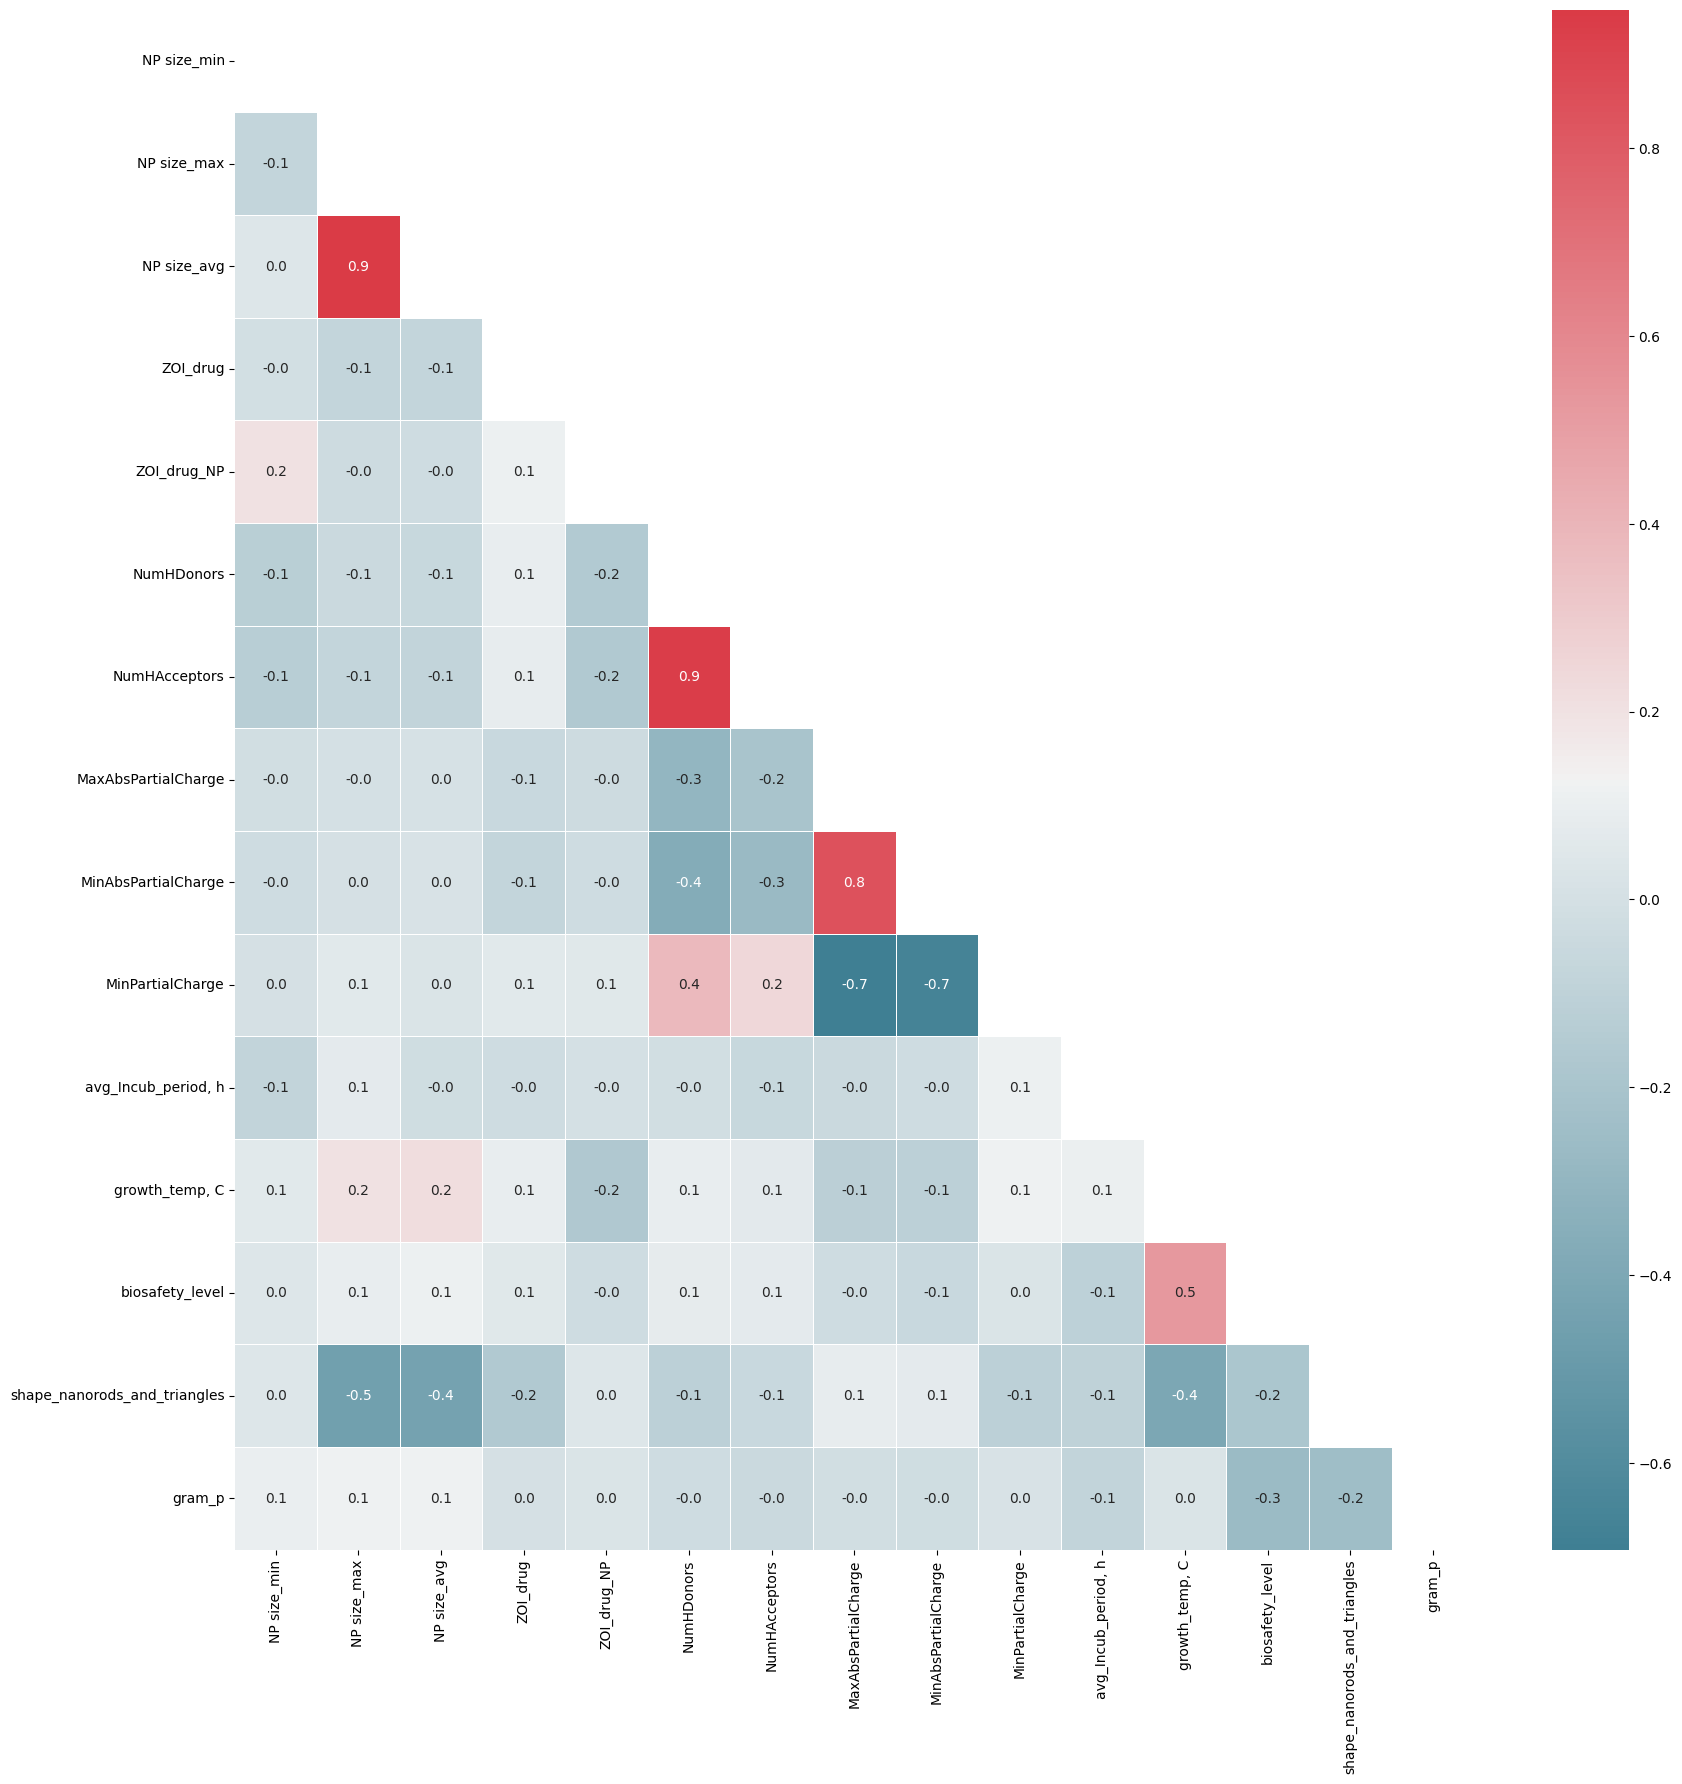

In [33]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20)) #создание графика и определение его размеров
cmap = sns.diverging_palette(220, 10, as_cmap=True) #создание палитры для корреляционного графика
sns.heatmap(corr, cmap=cmap, linewidths=.5, mask=mask, annot=True, fmt=".1f") 
#annot=True - вывод коэффициентов корреляции, fmt - число знаков после запятой, v - пределы, cmap - палитра, linewidth - толщина шрифта

Анализ

In [34]:
df

,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,"avg_Incub_period, h","growth_temp, C",biosafety_level,shape_nanorods_and_triangles,gram_p
0,4.0,10.0,8.0,17.0000,32.000,4.0,6.0,0.507967,0.327399,-0.507967,84.0,37.0,2.0,0.0,0
1,4.0,10.0,8.0,17.0000,32.000,1.0,5.0,1.000000,0.547832,-0.547832,84.0,37.0,2.0,0.0,0
2,15.0,30.0,28.0,17.0000,32.000,4.0,6.0,0.507967,0.327399,-0.507967,84.0,37.0,2.0,0.0,0
3,15.0,30.0,28.0,17.0000,32.000,1.0,5.0,1.000000,0.547832,-0.547832,84.0,37.0,2.0,0.0,0
4,5.0,30.0,21.0,0.0000,17.000,19.0,25.0,0.507810,0.330441,-0.507810,288.0,30.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,4.0,10.0,8.0,1.0000,0.125,4.0,6.0,0.507967,0.327399,-0.507967,36.0,37.0,2.0,0.0,1
580,5.0,80.0,60.0,0.3125,0.100,4.0,6.0,0.507967,0.327399,-0.507967,18.0,37.0,2.0,0.0,0
581,4.0,10.0,8.0,0.0300,0.030,8.0,12.0,0.387562,0.185232,-0.387562,36.0,37.0,2.0,0.0,1
582,15.0,30.0,28.0,0.0300,0.030,8.0,12.0,0.387562,0.185232,-0.387562,48.0,37.0,2.0,0.0,0


In [35]:
df.isna().sum()

NP size_min                     0
NP size_max                     0
NP size_avg                     0
ZOI_drug                        0
ZOI_drug_NP                     0
NumHDonors                      0
NumHAcceptors                   0
MaxAbsPartialCharge             0
MinAbsPartialCharge             0
MinPartialCharge                0
avg_Incub_period, h             0
growth_temp, C                  0
biosafety_level                 0
shape_nanorods_and_triangles    0
gram_p                          0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

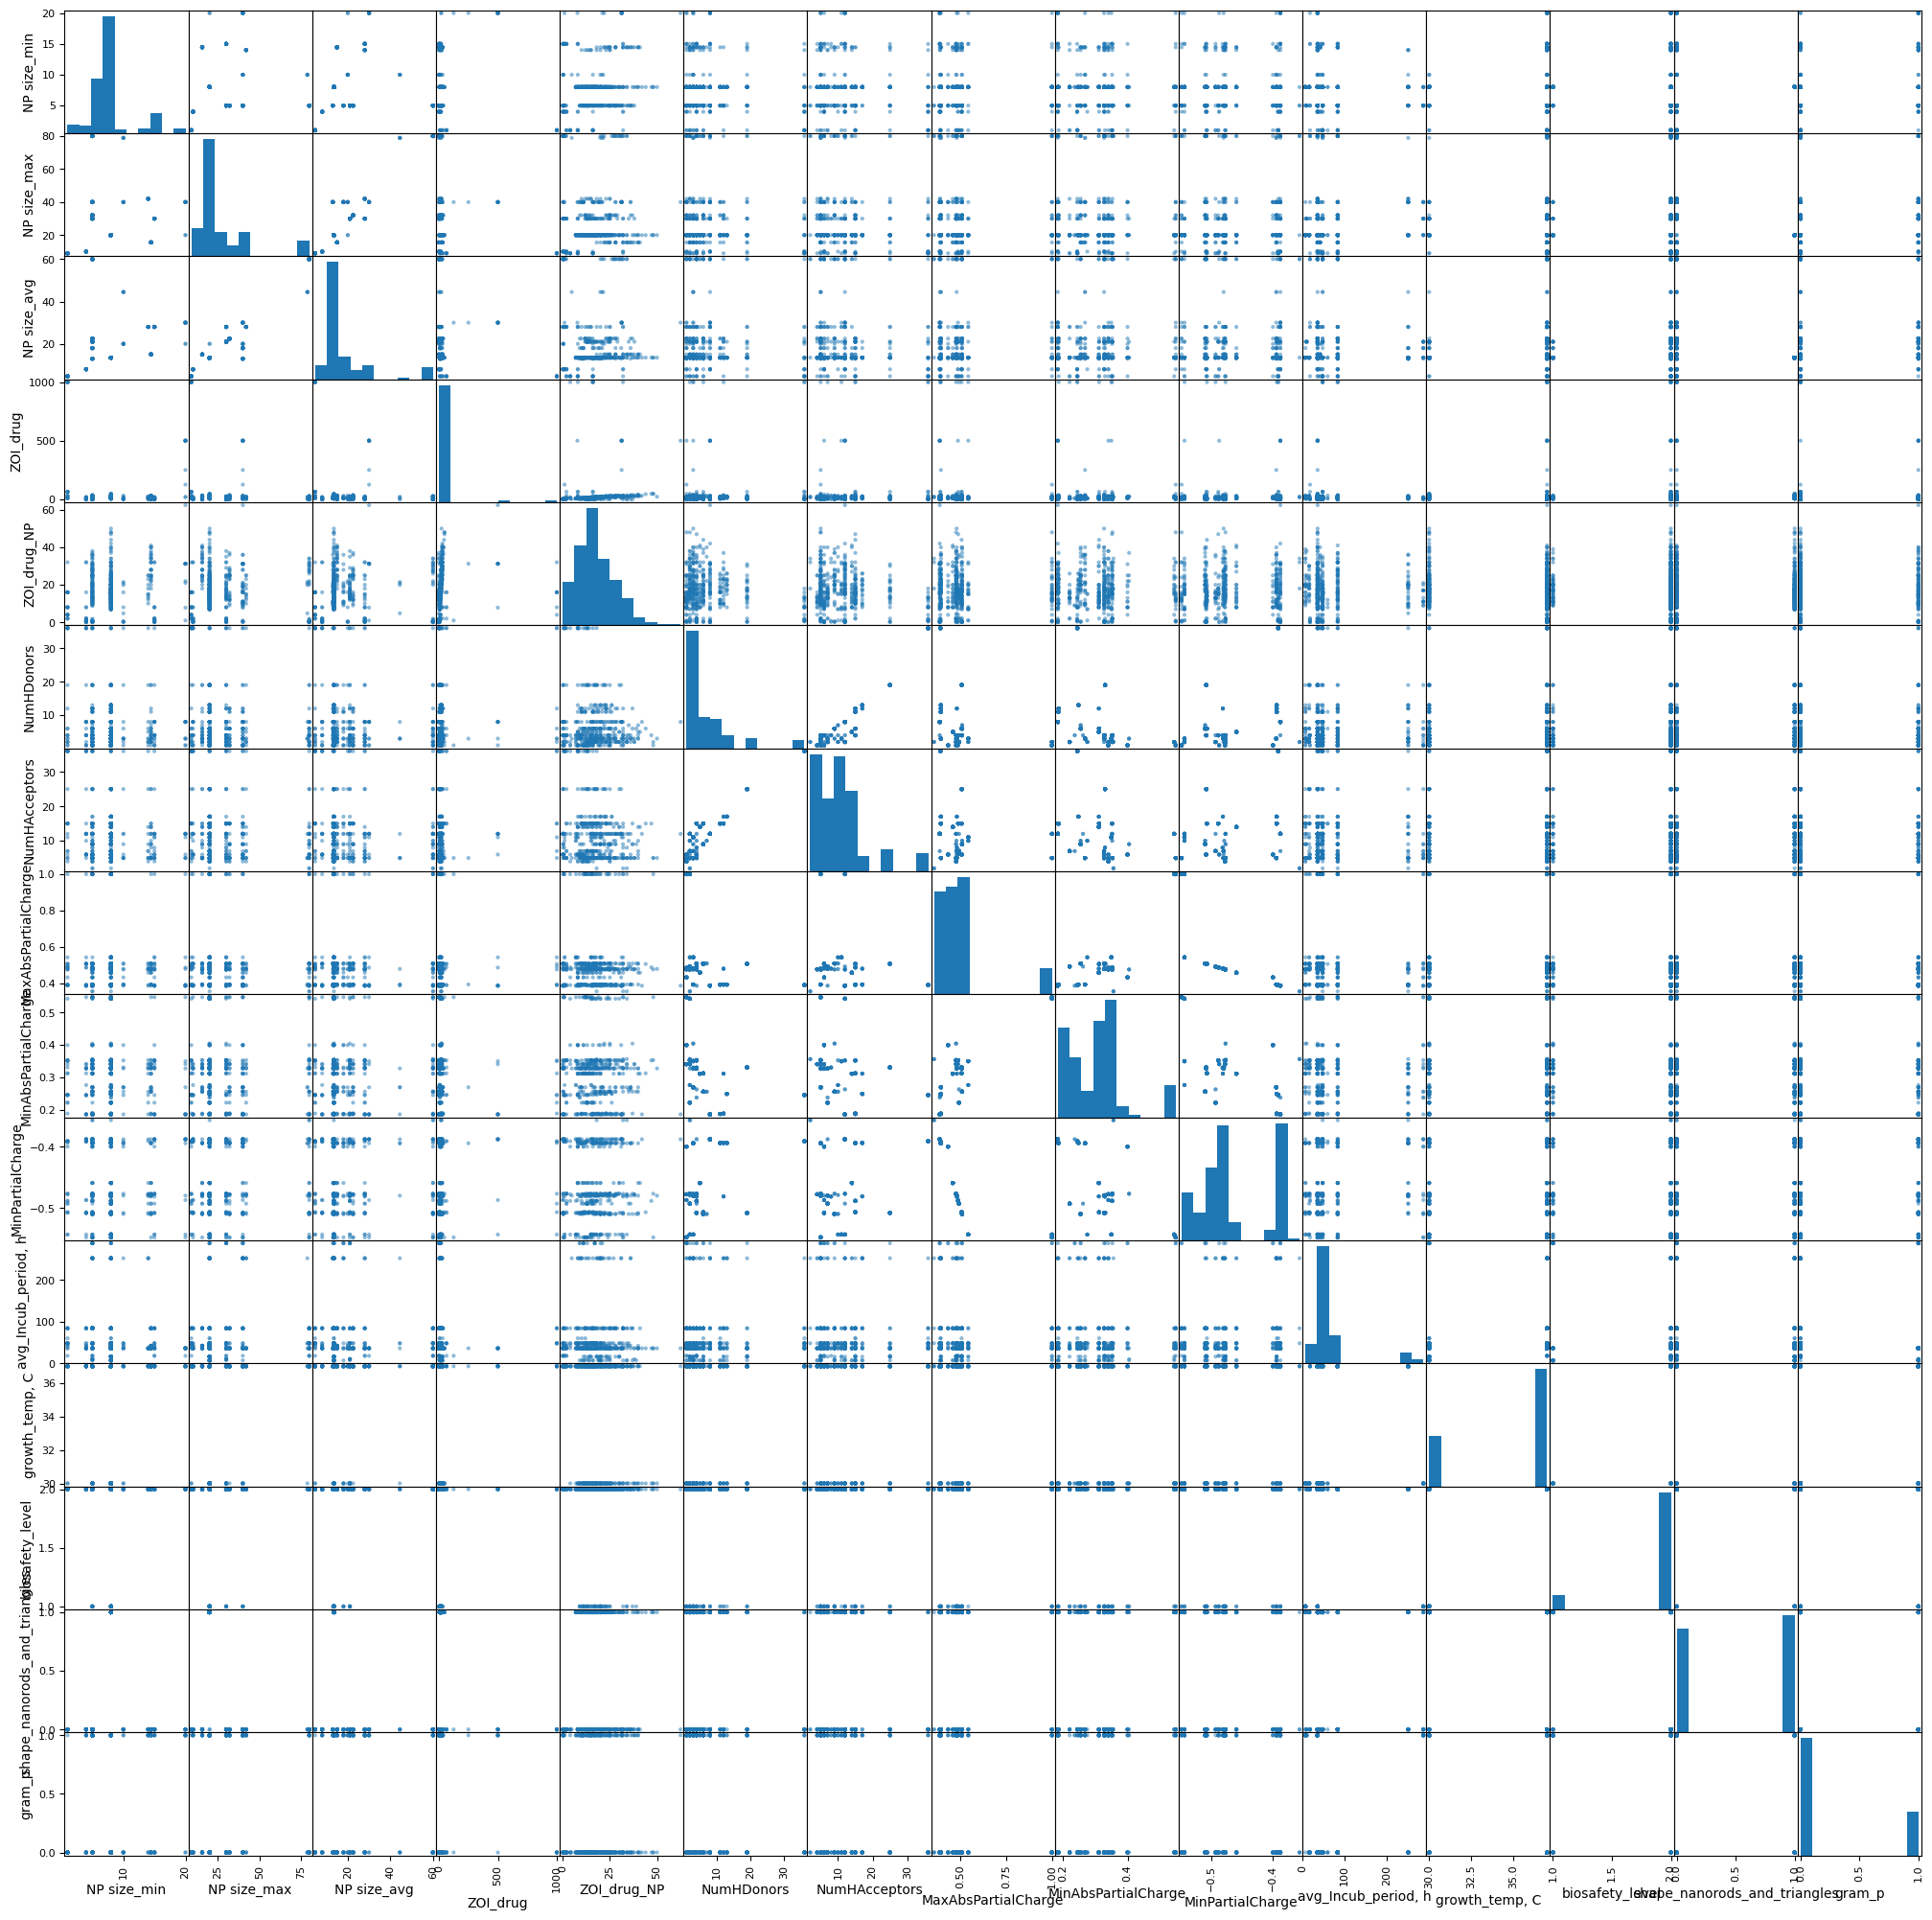

In [36]:
pd.plotting.scatter_matrix(df,figsize=(25,25),alpha=0.5)
plt.show

In [37]:
df.describe()

,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,"avg_Incub_period, h","growth_temp, C",biosafety_level,shape_nanorods_and_triangles,gram_p
count,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000
mean,7.861776,27.144953,18.551963,34.426533,17.208112,6.715888,11.244860,0.499559,0.307510,-0.464737,62.378991,34.906542,1.893458,0.530841,0.271028
std,3.520739,16.629425,12.215831,125.123221,9.921754,7.520610,7.317943,0.150407,0.090934,0.054366,63.337345,3.207939,0.308819,0.499515,0.444907
min,1.000000,9.000000,4.700000,0.000000,0.000000,1.000000,2.000000,0.356452,0.185232,-0.547832,7.000000,30.000000,1.000000,0.000000,0.000000
25%,5.000000,20.000000,13.500000,7.000000,11.000000,2.000000,5.000000,0.394123,0.247060,-0.507810,36.000000,30.000000,2.000000,0.000000,0.000000
50%,8.000000,20.000000,13.500000,15.000000,16.000000,4.000000,10.000000,0.478646,0.327399,-0.478646,42.000000,37.000000,2.000000,1.000000,0.000000
75%,8.000000,30.000000,21.000000,21.000000,23.000000,8.000000,15.000000,0.507810,0.340725,-0.394123,48.000000,37.000000,2.000000,1.000000,1.000000
max,20.000000,80.000000,60.000000,1000.000000,62.500000,36.000000,36.000000,1.000000,0.547832,-0.356452,288.000000,37.000000,2.000000,1.000000,1.000000


In [38]:
df.to_csv('df_result_1.csv')

NP size_min


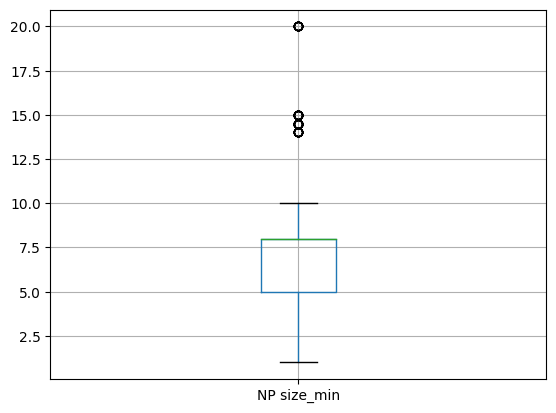

NP size_max


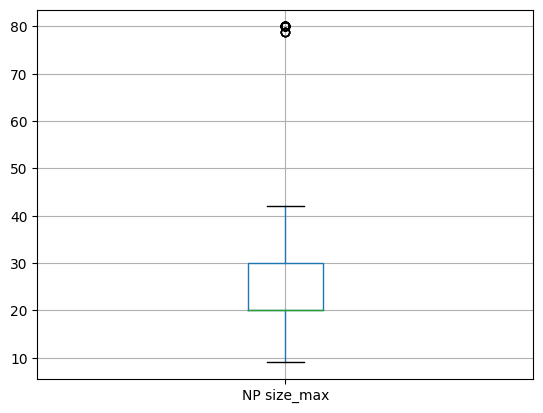

NP size_avg


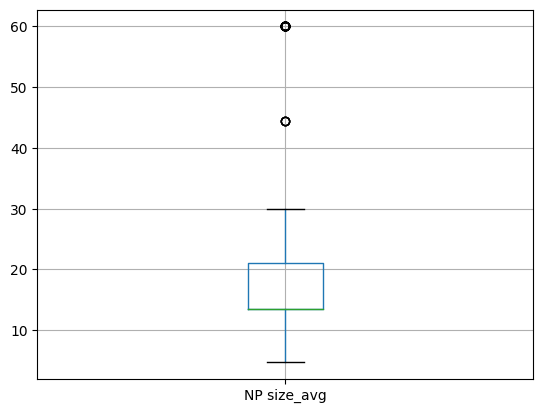

ZOI_drug


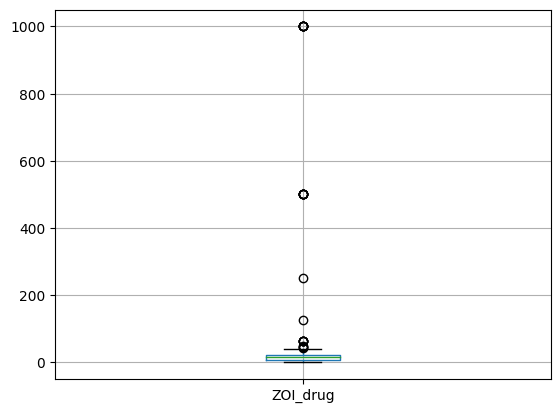

ZOI_drug_NP


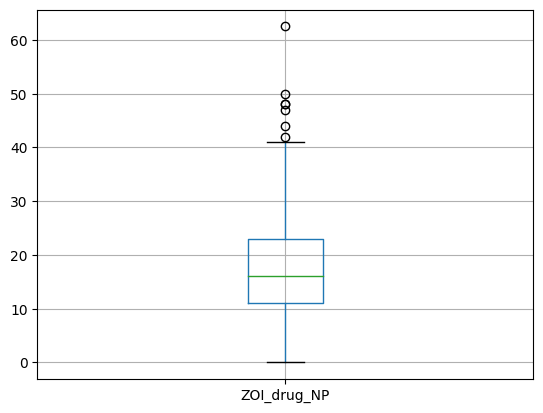

NumHDonors


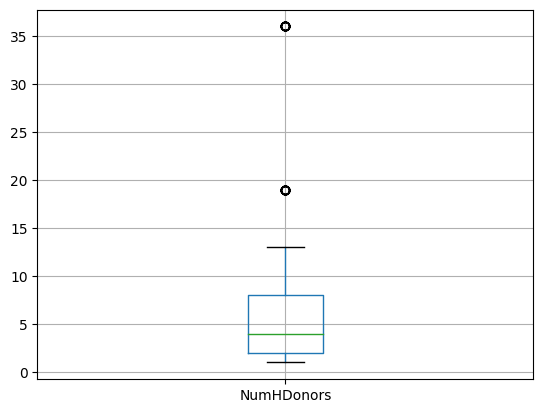

NumHAcceptors


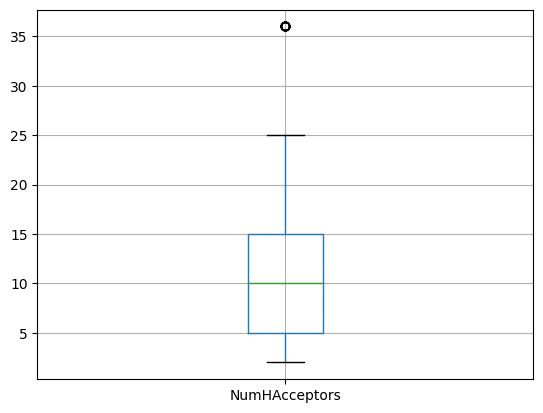

MaxAbsPartialCharge


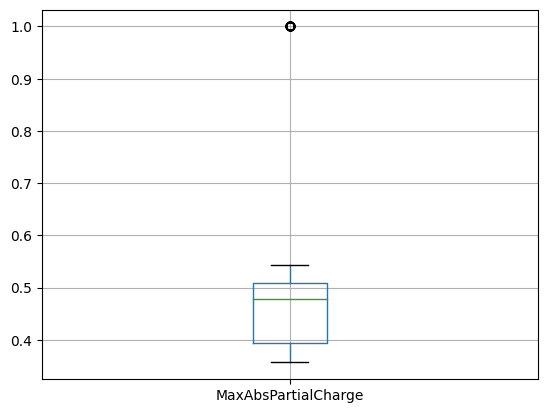

MinAbsPartialCharge


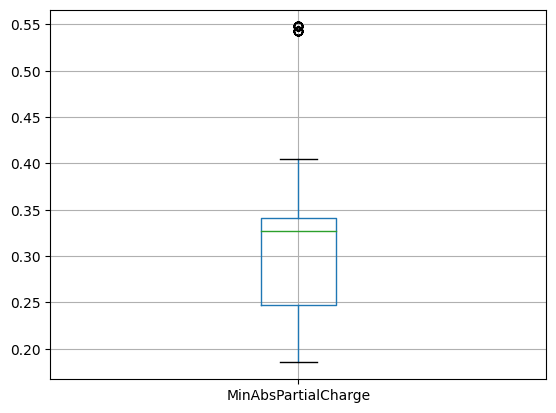

MinPartialCharge


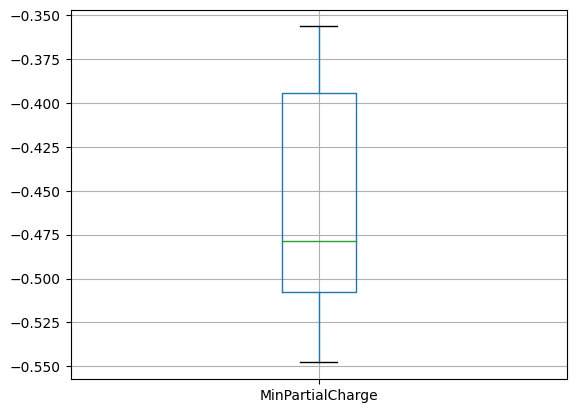

avg_Incub_period, h


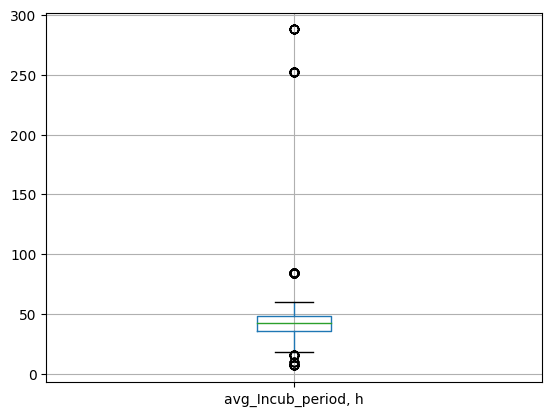

growth_temp, C


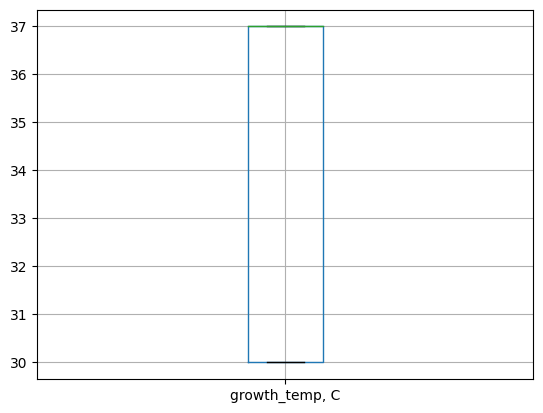

biosafety_level


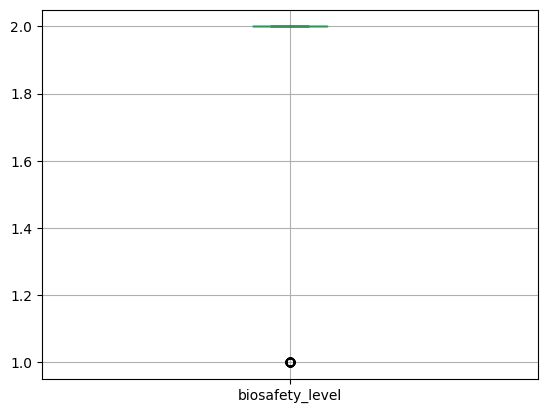

shape_nanorods_and_triangles


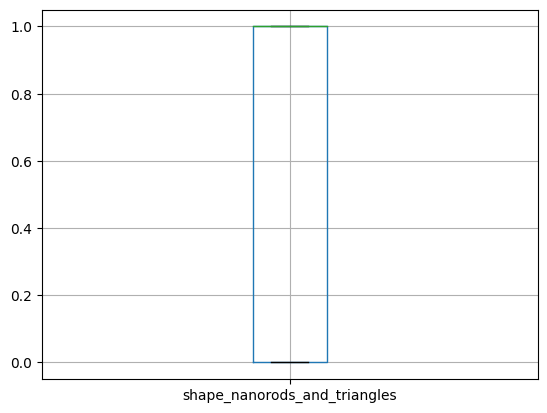

gram_p


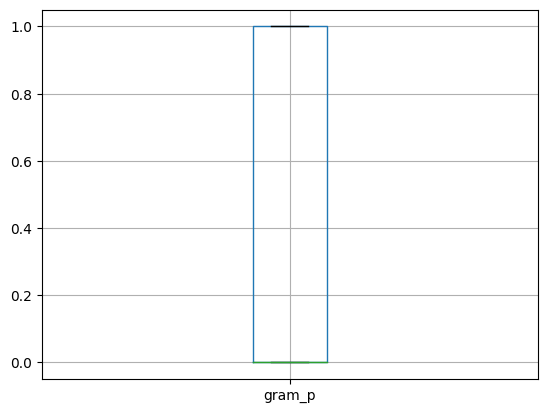

In [39]:
for item in df.columns:
    print(item)
    df.boxplot(item)
    plt.show()

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 0 to 583
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NP size_min                   535 non-null    float64
 1   NP size_max                   535 non-null    float64
 2   NP size_avg                   535 non-null    float64
 3   ZOI_drug                      535 non-null    float64
 4   ZOI_drug_NP                   535 non-null    float64
 5   NumHDonors                    535 non-null    float64
 6   NumHAcceptors                 535 non-null    float64
 7   MaxAbsPartialCharge           535 non-null    float64
 8   MinAbsPartialCharge           535 non-null    float64
 9   MinPartialCharge              535 non-null    float64
 10  avg_Incub_period, h           535 non-null    float64
 11  growth_temp, C                535 non-null    float64
 12  biosafety_level               535 non-null    float64
 13  shape

In [41]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [42]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
        
    outliers = pd.Series(data=[False]*len(data), index=data_features.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    
    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))   

In [43]:
data_features = df.iloc[:, :]
data_features

,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,"avg_Incub_period, h","growth_temp, C",biosafety_level,shape_nanorods_and_triangles,gram_p
0,4.0,10.0,8.0,17.0000,32.000,4.0,6.0,0.507967,0.327399,-0.507967,84.0,37.0,2.0,0.0,0
1,4.0,10.0,8.0,17.0000,32.000,1.0,5.0,1.000000,0.547832,-0.547832,84.0,37.0,2.0,0.0,0
2,15.0,30.0,28.0,17.0000,32.000,4.0,6.0,0.507967,0.327399,-0.507967,84.0,37.0,2.0,0.0,0
3,15.0,30.0,28.0,17.0000,32.000,1.0,5.0,1.000000,0.547832,-0.547832,84.0,37.0,2.0,0.0,0
4,5.0,30.0,21.0,0.0000,17.000,19.0,25.0,0.507810,0.330441,-0.507810,288.0,30.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,4.0,10.0,8.0,1.0000,0.125,4.0,6.0,0.507967,0.327399,-0.507967,36.0,37.0,2.0,0.0,1
580,5.0,80.0,60.0,0.3125,0.100,4.0,6.0,0.507967,0.327399,-0.507967,18.0,37.0,2.0,0.0,0
581,4.0,10.0,8.0,0.0300,0.030,8.0,12.0,0.387562,0.185232,-0.387562,36.0,37.0,2.0,0.0,1
582,15.0,30.0,28.0,0.0300,0.030,8.0,12.0,0.387562,0.185232,-0.387562,48.0,37.0,2.0,0.0,0


In [44]:
comparison_table, std_outliers = get_column_outliers(data_features)
anomalies_report(std_outliers)

Total number of outliers: 124
Percentage of outliers:   23.18%


C:\Users\Алексей\AppData\Local\Temp\ipykernel_11088\1154824153.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
C:\Users\Алексей\AppData\Local\Temp\ipykernel_11088\1154824153.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
C:\Users\Алексей\AppData\Local\Temp\ipykernel_11088\1154824153.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
C:\Users\Алексей\AppData\Local\Temp\ipykernel_11088\1154824153.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  anomalies = pd.concat([d

In [45]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
NP size_min,18.423992,-2.700440,11.0,2.056075
NP size_max,77.033228,-22.743322,38.0,7.102804
NP size_avg,55.199456,-18.095530,34.0,6.355140
ZOI_drug,409.796194,-340.943129,14.0,2.616822
ZOI_drug_NP,46.973374,-12.557150,5.0,0.934579
NumHDonors,29.277719,-15.845943,22.0,4.112150
NumHAcceptors,33.198689,-10.708969,22.0,4.112150
MaxAbsPartialCharge,0.950780,0.048338,40.0,7.476636
MinAbsPartialCharge,0.580312,0.034707,0.0,0.000000
MinPartialCharge,-0.301639,-0.627835,0.0,0.000000


In [46]:
other_features = [col for col in df.columns ]
other_features

['NP size_min',
 'NP size_max',
 'NP size_avg',
 'ZOI_drug',
 'ZOI_drug_NP',
 'NumHDonors',
 'NumHAcceptors',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'MinPartialCharge',
 'avg_Incub_period, h',
 'growth_temp, C',
 'biosafety_level',
 'shape_nanorods_and_triangles',
 'gram_p']

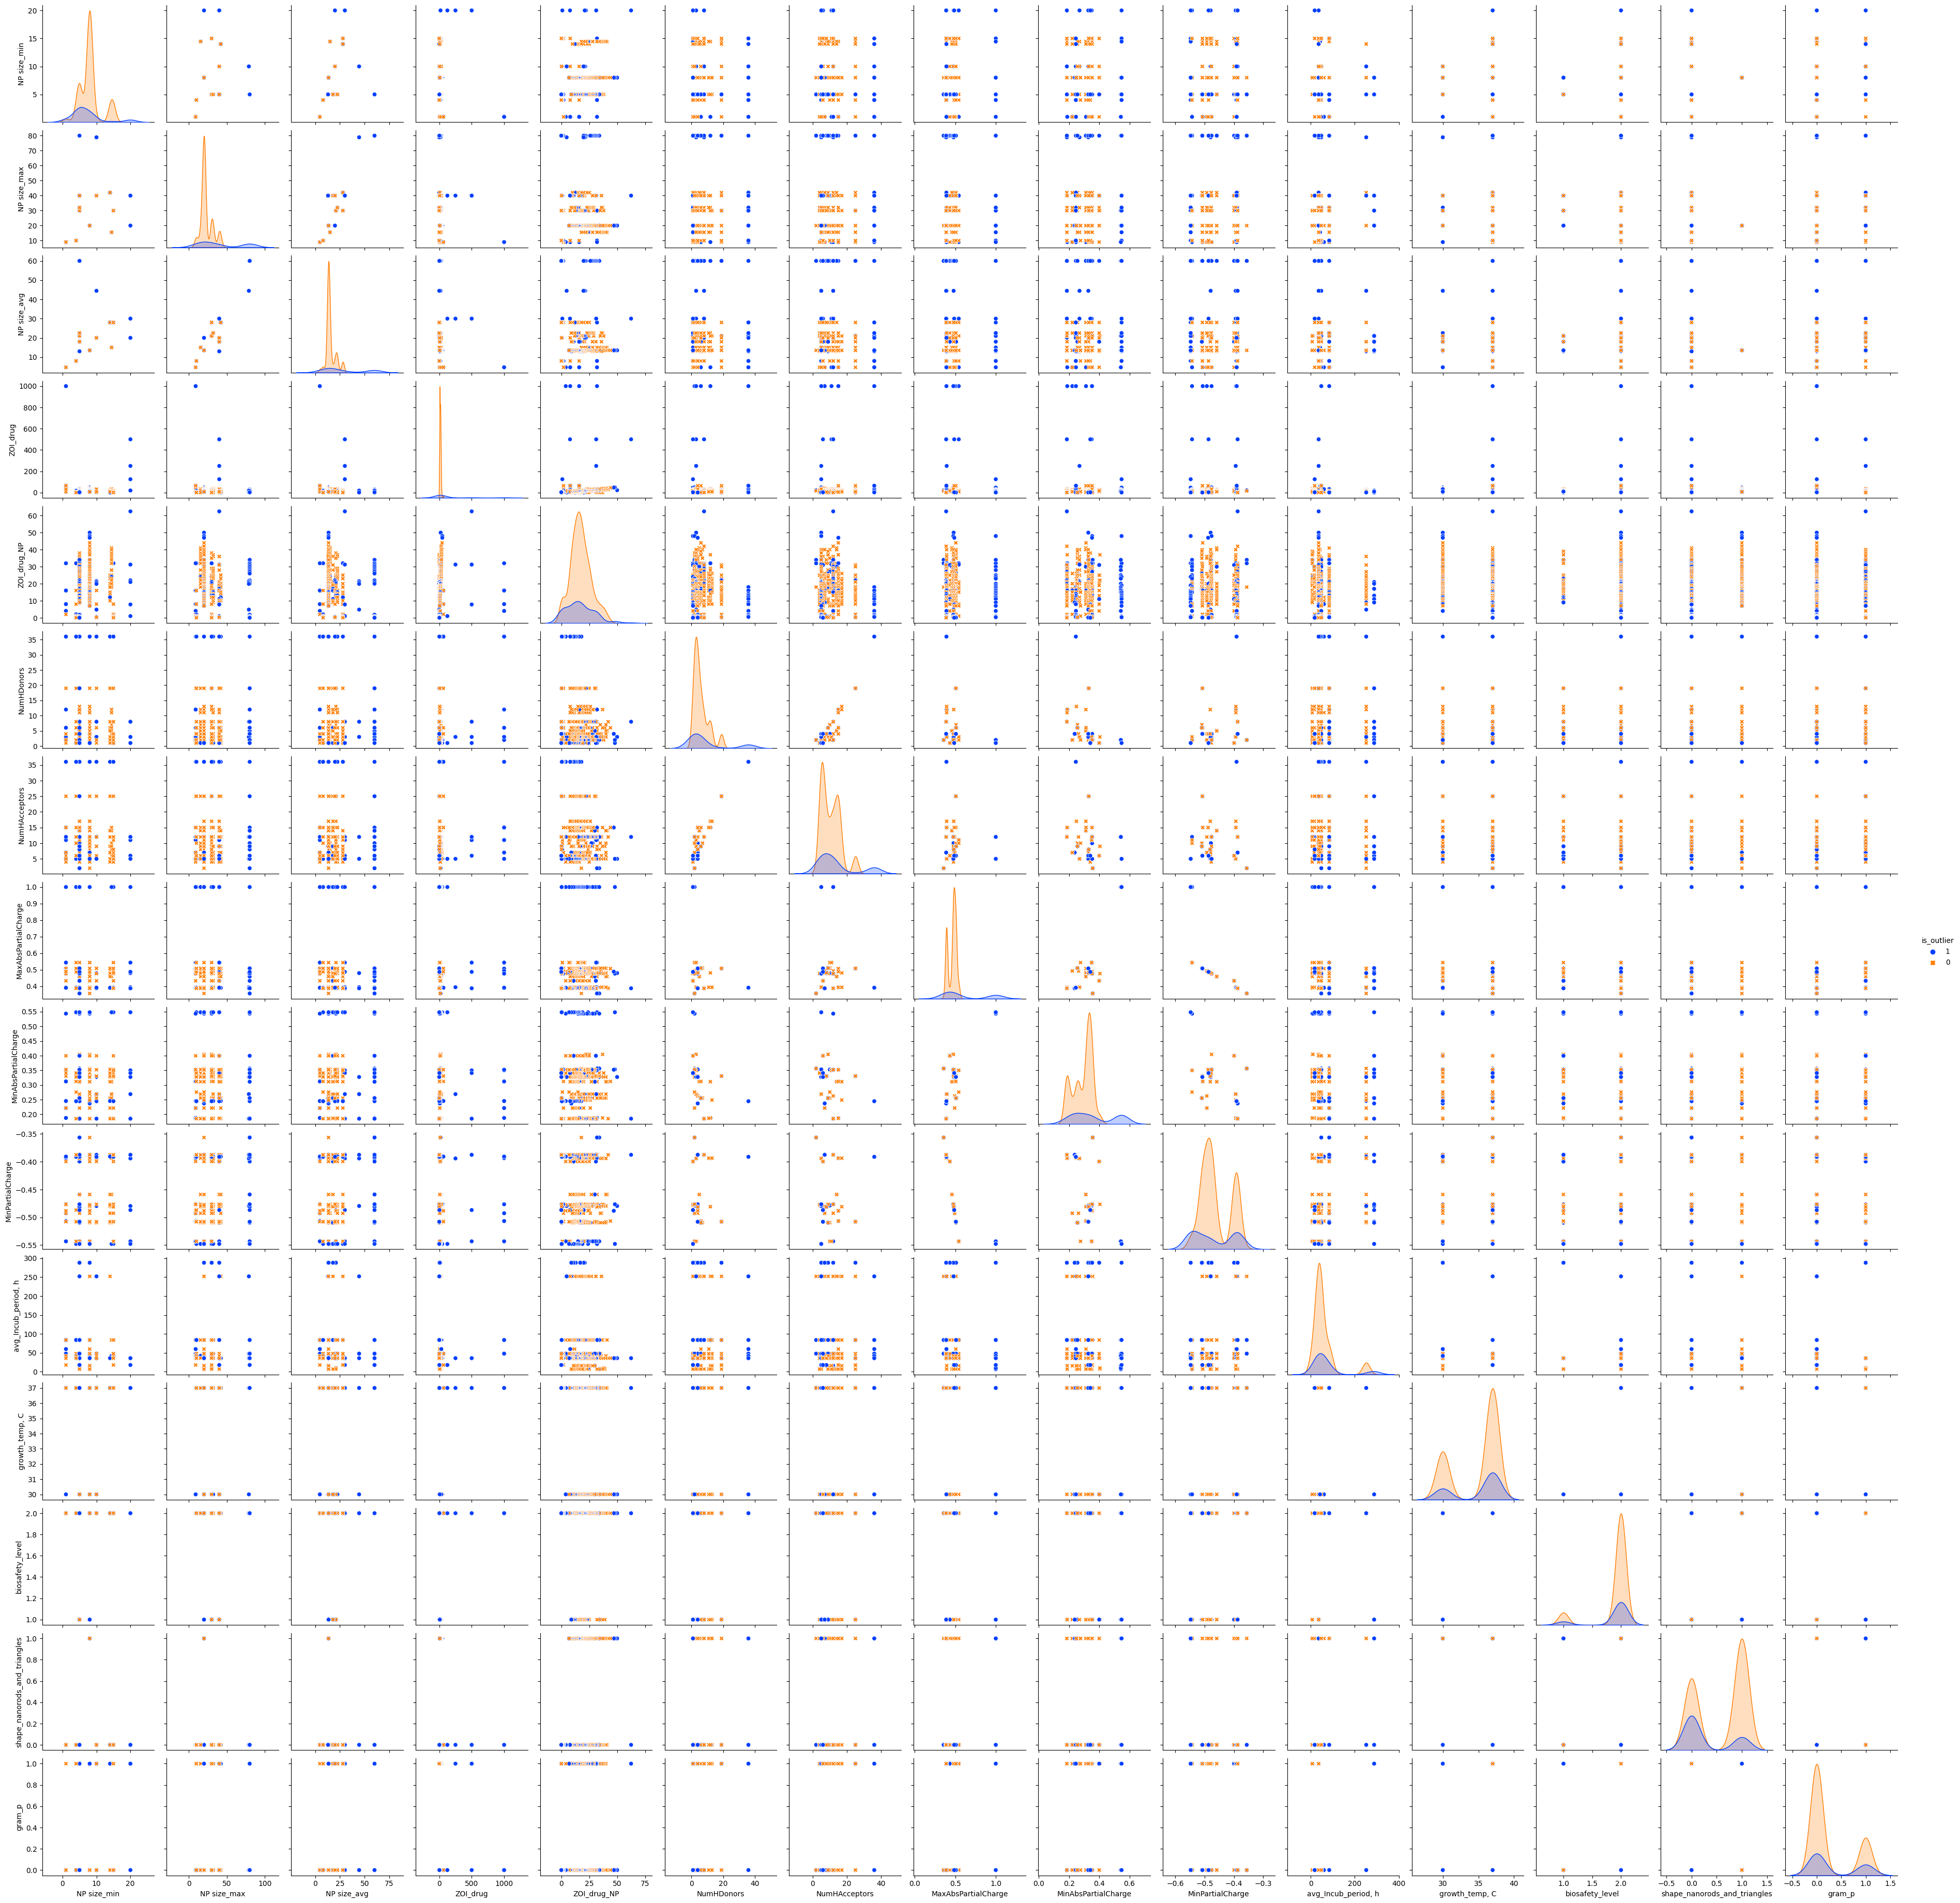

In [47]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = std_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

Анализ данных позволил сделать следующие выводы:

Присутствуют нулевые значения эффективности препарата, которые не несут информативности. в дальнейшем удалим эти нулевые значения, чтобы они не вносили шум в модели.

Значения показателя ZOI_drug, превышающие 60, можно считать выбросами. Следует обратить внимание на эти значения, так как они могут исказить анализ и результаты моделирования.

Наблюдается разнообразие источников данных и методов расчетов, что может привести к неточностям и неоднородности в данных. Это может повлиять на стабильность и качество моделей.

Важно отметить, что в идеале требует дополнительной очистки и приведения к однородному формату. Однако, учитывая ограниченный объем данных, решено не проводить дополнительную очистку для сохранения ценной информации.